- [assignments 1 page](https://www.csie.ntu.edu.tw/~cyy/courses/vfx/22spring/assignments/proj1/)
- Author: R10944007 曾宏鈞, 許博翔 

/var/folders/k2/f1x8q4fn6sgcjt45z33pnccr0000gn/T/ipykernel_96794/3863885422.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(4, len(images)/4, i+1)


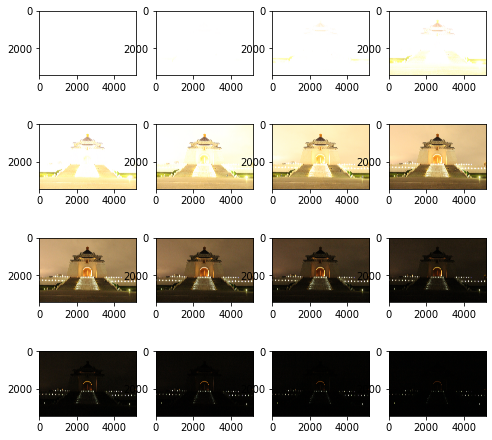

In [52]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

# path = "../data/Memorial_SourceImages/*png"
path = "../data/cksMemorial/*JPG"
files = glob.glob(path)
files.sort(reverse=True)
images = [cv2.imread(f) for f in files][:-2]
shutter_speed = np.array([1/32, 1/16, 1/8., 1/4, 1/2, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

plt.figure(figsize=(8,8))
for i in range(len(images)):
    plt.subplot(4, len(images)/4, i+1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

# Image Alignment 
- Median Threshold Bitmap Alignment (MTB)
    
    


In [2]:
def Gray(img):
    """
    convert image to grayscale
    """
    return np.array([[(54*x[2]+183*x[1]+19*x[0])/256 for x in y] for y in img], dtype="uint8")
def ImageShrink2(img):
    """
    shrink image by 2
    """
    return np.array( [[(int(img[y][x]) + int(img[y+1][x]) + int(img[y][x+1]) + int(img[y+1][x+1]))/4  for x in range(0, img.shape[1]-1, 2)] for y in range(0, img.shape[0]-1, 2)], dtype='uint8')
def ComputeBitmaps(img):
    """
    compute median threshold bitmap and exclusion bitmap
    """
    h, w = img.shape
    threshold = 10
    median = int( np.median(img) )
    threshold_bitmap = np.zeros((h,w))
    threshold_bitmap[ img>median ] = 1
    exclusion_bitmap = np.ones((h,w))
    exclusion_bitmap[ np.where(np.abs(img - median) <= threshold) ] = 0
    return threshold_bitmap, exclusion_bitmap
def BitmapShift(bm, x, y):
    """
    shift image by x, y
    """
    ans = bm.copy()
    if (x<0):
        ans[:, :-x] = ans[:, x:]
    elif (x>0):
        ans[:, x:] = ans[:, :-x]
    if (y<0):
        ans[:-y, :] = ans[y:, :]
    elif (y>0):
        ans[y:, :] = ans[:-y, :]    
    return ans


# ref: [1] - Overall algorithm
def getExpShift(img1, img2, shiftBits):
    if (shiftBits>0):
        sml_img1 = ImageShrink2(img1)
        sml_img2 = ImageShrink2(img2)
        cur_shift = getExpShift(sml_img1, sml_img2, shiftBits-1)
        cur_shift[0] *= 2
        cur_shift[1] *= 2
    else:
        cur_shift = [0,0]
    tb1, eb1 = ComputeBitmaps(img1)
    tb2, eb2 = ComputeBitmaps(img2)
    min_err = img1.shape[0] * img2.shape[1]
    for y in range(-1, 2):
        for x in range(-1, 2):
            xs = cur_shift[0] + x
            ys = cur_shift[1] + y
            shifted_tb2 = BitmapShift(tb2, xs, ys)
            shifted_eb2 = BitmapShift(eb2, xs, ys)
            diff_b = np.logical_xor(tb1, shifted_eb2)
            diff_b = np.logical_and(diff_b, eb1)
            diff_b = np.logical_and(diff_b, shifted_eb2)
            err = diff_b.sum()
            if (err<min_err):
                shift_ret = [xs, ys] 
                min_err = err
    return shift_ret 

level = 1
image_shifted = [images[0]]
for i in range(1, len(images)):
    g1 = Gray(images[0]) 
    g2 = Gray(images[i]) 
    x, y = getExpShift(g1, g2, level)
    image_shifted.append(BitmapShift(images[i], x, y))
    print(x, y)

3 0
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
1 3
-2 3
-3 3
-2 3
-3 3


In [53]:
## 這邊不確定可不可以直接使用cv2.resize
sample = [] #np.array(image_shifted.copy())
for i in range(len(image_shifted)):
    sample.append( cv2.resize(images[i], (10,10), interpolation = cv2.INTER_AREA) )
sample = np.array(sample)

print(sample.shape)
sample = np.transpose(sample, (3, 1, 2, 0))
sample = sample.reshape((sample.shape[0], sample.shape[1]*sample.shape[2], sample.shape[3]))
print(sample.shape) # (bgr channels, pixels, pictures)

(16, 10, 10, 3)
(3, 100, 16)


In [54]:
# Weight functions
mu = np.mean(range(256))
sigma = np.std(range(256))
# Normal distribution pdf
normal = lambda x: (1 / (sigma * (2 * np.pi)**0.5)) * np.exp( (-1/2) * (((x - mu) /sigma)**2))
# None
none = lambda x: x

# 1/Distance
distance = lambda x: 1 - abs(x - mu) - mu

In [55]:
# recover camera response curve
# Paul Debevec's method
# return camera response function g
# 解 Ax=b np.linalg.lstsq(A, b)

# Arguments
"""
Input:
    Z: i pixel in j image
    B: log(delta t)
    l: constant of smoothness
    w: weight of pixel z
Output:
    g(z)
    lE(i)
"""
shutter_time = 1/shutter_speed
B = np.log(shutter_time)
l = 70 # 我隨便設
w = normal


In [56]:
# gsolve(Z, B, l, w)
def gsolve(Z, B, l, w):
   
    n = 256
    A = np.zeros((Z.shape[0]*Z.shape[1]+(n-2)+1, n+Z.shape[0]), dtype=np.float32)
    b = np.zeros((A.shape[0], 1), dtype=np.float32)
    W = np.zeros(Z.shape, dtype=np.float32)


    ## 算np
    k=0
    for i in range(0, Z.shape[0]):
        for j in range(0, Z.shape[1]):
            W[i][j] = w(Z[i][j])
            A[k][ Z[i][j] ] = W[i][j]
            A[k][n+i] = -W[i][j]
            b[k][0] = W[i][j] * B[j]
            k+=1

    A[k][127] = 1
    k+=1

    for i in range(0, n-2):
        weight = w(i+1)
        A[k][i] = l * weight
        A[k][i+1] = -2 * l*weight
        A[k][i+2] = l * weight
        k+=1

    print(A.shape, b.shape)
    from scipy.linalg import lstsq
    x = lstsq(A, b)

    g=x[0][:n]
    lE = x[0][n:]
    print(g.shape, lE.shape)
    return g, lE

gs, lEs = [], []
for i in range(3):
    Z = sample[i]
    print(Z.shape)
    g, lE = gsolve(Z, B, l, w)
    gs.append(g)
    lEs.append(lE)


(100, 16)
(1855, 356) (1855, 1)
(256, 1) (100, 1)
(100, 16)
(1855, 356) (1855, 1)
(256, 1) (100, 1)
(100, 16)
(1855, 356) (1855, 1)
(256, 1) (100, 1)


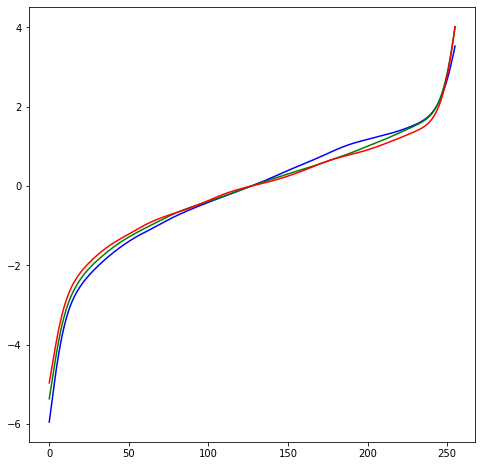

In [58]:
colors = ["blue", "green", "red"]
plt.figure(figsize=(8,8))
for i in range(3):
    plt.plot(range(256), gs[i], color=colors[i])
plt.show()

In [ ]:
# Debevec's method
def debevec():
    A_inv = np.linalg.pinv(A)
    lnG = np.dot(A_inv, b)
    print(lnG.shape)
    return lnG

In [ ]:
# construct radiance map



In [ ]:
i=8
print(ans[i].shape)
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(ans[0], cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(ans[i], cv2.COLOR_BGR2RGB))

NameError: name 'ans' is not defined

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11],
        [12, 13],
        [13, 14]]])

# Ref
1. Ward, G. (2003). Fast, robust image registration for compositing high dynamic range photographs from hand-held exposures. Journal of graphics tools, 8(2), 17-30.